## Paquetes

In [1]:
import pandas as pd
import openpyxl
from tqdm import tqdm
import unidecode
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import warnings
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import math
from operator import itemgetter

import unidecode
import string
import re
from fuzzywuzzy import fuzz
import os
import traceback
from scipy.stats import ttest_ind

import rddensity
from rdrobust import rdrobust,rdbwselect,rdplot
import statsmodels.api as sm
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm

# Pre procesamiento

## Creación de carpetas

In [254]:
carpeta1 = "OUT_2_TESTS"
if not os.path.exists(carpeta1):
    os.makedirs(carpeta1)

carpeta3 = "OUT_3_RD_GRAPHS"
if not os.path.exists(carpeta3):
    os.makedirs(carpeta3)

carpeta2 = "OUT_4_RD_TABLES"
if not os.path.exists(carpeta2):
    os.makedirs(carpeta2)

carpeta4 = "OUT_5_RD_ROBUST"
if not os.path.exists(carpeta4):
    os.makedirs(carpeta4)

carpeta5 = "OUT_6_RD_COUNCIL"
if not os.path.exists(carpeta5):
    os.makedirs(carpeta5)


## Procesamiento de data electoral

In [119]:
########################################################## PARAMETROS
año_t0 = 2011      #PERIODO DE TRIUNFO EN PRIMER ELECCIÓN
año_t1 = año_t0 + 4 #PERIODO DE REPETICIÓN O NO REPETICIÓN
años_ev = [año_t1+1, año_t1+2, año_t1+3, año_t1+4] #AÑOS CONSIGUIENTES DESPUES DE LA REPETICIÓN

########################################################## IMPORTACION
data_electoral_procesada = "OUT_1_DATA_ELECTORAL_PROCESADA"
data_electoral_raw = "INPUT_1_DATA_ELECTORAL"
partidos = pd.read_excel(f"{data_electoral_procesada}//Partidos_Electorales_Long.xlsx")

### Procesamiento según los parámetros

General

In [122]:
################################################################################################################
# PROCESAMIENTO DE LOS DATOS ELECTORALES

################################################################################################################
# PRIMER PERIODO
dfg = pd.read_stata(f"{data_electoral_raw}/Alcaldías/{año_t0}_alcaldia.dta")
df = dfg.copy()

nulos = df[["codmpio", "codigo_lista"]]
nulos = nulos[nulos["codigo_lista"]==998]
nulos.columns = ["codmpio", "votos_nulos"]
df = df.sort_values(by = ["codmpio", "votos"], ascending= [True, False])
df = pd.merge(df, nulos, "left", "codmpio")

df["votos_porcentaje"] = df["votos"]/(df["censoe_total"]-df["votos_nulos"])
df[f"votos_segundo"] = df.groupby(["codmpio"]).shift(-1)["votos_porcentaje"]

df = df[df.curules == 1]
df = df.rename(columns = {"votos_porcentaje": "votos_primero"})

df = df[['ano', 'municipio', 'codmpio', 'codigo_partido', 'primer_apellido', 'votos_primero', 'votos_segundo']]
dff = df.copy()
dff = dff.merge(partidos, "left", "codigo_partido")

dff.columns = [col if col in ['codmpio', 'municipio', 'miembros_code'] else f'{col}_{año_t0}' for col in dff.columns]

#################################################################################################################
# SEGUNDO PERIODO
dfg = pd.read_stata(f"{data_electoral_raw}/Alcaldías/{año_t1}_alcaldia.dta")

df = dfg.copy()

nulos = df[["codmpio", "codigo_lista"]]
nulos = nulos[nulos["codigo_lista"]==998]
nulos.columns = ["codmpio", "votos_nulos"]
df = df.sort_values(by = ["codmpio", "votos"], ascending= [True, False])
df = pd.merge(df, nulos, "left", "codmpio")

df["votos_porcentaje"] = df["votos"]/(df["censoe_total"]-df["votos_nulos"])
df = df[['ano', 'codmpio', 'codigo_partido', 'primer_apellido', 'curules','votos_porcentaje']]
df[f"votos_segundo"] = df.groupby(["codmpio"]).shift(-1)["votos_porcentaje"]

primeros = df[df.curules==1]
primeros = primeros[["ano", "codmpio", "votos_porcentaje"]]
primeros.columns = ["ano", "codmpio", "votos_primero"]

df = pd.merge(df, primeros, "left",  ["ano", "codmpio"])
df["diferencia"] = np.where(df["curules"] == 0, df["votos_porcentaje"] - df["votos_primero"], df["votos_porcentaje"] - df["votos_segundo"])

df_long = df.merge(partidos, "left", "codigo_partido") #AQUI SI HAY MÁS DE UN PARTIDO EN UNA COALICIÓN Y ESA COALICIÓN GANA ENTONCES A CADA PARTIDO LE APARECE UN 1 EN CURULES
df_long.columns = [col if col in ['codmpio', 'miembros_code'] else f'{col}_{año_t1}' for col in df_long.columns]

################################################################################################################ LOS QUE GANARON EN T-4, ¿QUE LES PASO EN LA SIGUIENTE ELECCIÓN?
dff = dff.merge(df_long, "left", ["codmpio", "miembros_code"])
dff = dff.sort_values(by = ["codmpio", f"curules_{año_t1}"], ascending = [True, False]).drop_duplicates(["codmpio"])
dff = dff[dff[f"curules_{año_t1}"].notna()]

# dff[f"curules_{año_t1}"].sum()

Concejos

In [123]:
#CODIGO PARTIDO 2015 ES LA COALICIÓN (para MUNICIPIO 5134, EL LIBERAL (19910006.0) EN 2011 ESTUVO EN LA COALICIÓN GANADORA EN 2015 (20150010.0))

# PROCESAMIENTO DE CONCEJOS (PROPORCIÓN DE VOTOS POR PARTIDO)
concejo = pd.read_stata(f"INPUT_1_DATA_ELECTORAL/Concejos/{año_t1}_concejo.dta")
concejoc = concejo.groupby(["codmpio", "codigo_partido"])[["curules"]].sum().reset_index()
curules_totales = concejo.groupby(["codmpio"])[["curules"]].sum().reset_index(); curules_totales.columns = ["codmpio", "curules_totales"]
concejoc = concejoc.merge(curules_totales, "left", "codmpio")
concejoc["curules_share"] = concejoc["curules"]/concejoc["curules_totales"]

dffp = dff[["codmpio", f"codigo_partido_{año_t1}"]] #DATAFRAME FINAL, SOLO CON EL CODIGO DEL MUNICIPIO + EL CODIGO DE LA COALICIÓN (2015)
dffp.columns = ["codmpio", "codigo_partido"] #CAMBIAR EL NOMBRE, 760 REGISTROS
dffp = dffp.merge(partidos, "left", "codigo_partido") #PEGUE CON EL DATAFRAME DE PARTIDOS (VAN A QUEDAR MÁS REGISTROS, POR LAS COALICIONES)
concejoc = concejoc.rename(columns = {"codigo_partido":"miembros_code"}) #CAMBIO EL NOMBRE A MIEMBROS PORQUE EN CONCEJO TIENE LOS VOTOS POR PARTIDOS (NO X COALICIÓN)
dffp = dffp.merge(concejoc, "left", ["codmpio", "miembros_code"])
dffp = dffp.groupby(["codmpio", "codigo_partido"])[["curules_share"]].sum().reset_index()
dffp.columns = ["codmpio", f"codigo_partido_{año_t1}", f"curules_share_{año_t1}"]

Nombramiento de columnas

In [ ]:
dff = dff.merge(dffp, "left", ["codmpio", f"codigo_partido_{año_t1}"])
dff = dff[["codmpio", f"votos_porcentaje_{año_t1}", f"diferencia_{año_t1}", 
           f"miembros_clean_{año_t1}", f"tipo_{año_t1}", f"curules_share_{año_t1}"]]

dffg = dff[np.abs(dff[f"votos_porcentaje_{año_t1}"])<=1]
dffg = dffg[np.abs(dffg[f"diferencia_{año_t1}"])<=1]

dffg["votos_complemento"] = dff[f"votos_porcentaje_{año_t1}"] - dffg[f"diferencia_{año_t1}"]
dffg["total votos"] = dffg["votos_complemento"] + dff[f"votos_porcentaje_{año_t1}"]
dffg= dffg[dffg["total votos"]<=1]

En caso de querar alguna X de algún año (para los placesbos)

In [127]:
# dffg[["codmpio", f"diferencia_{año_t1}"]].to_excel(f"OUT_2_TESTS/{año_t1}_X.xlsx", index = False)

# Descriptivo

## Gráfica margen vs voteshare

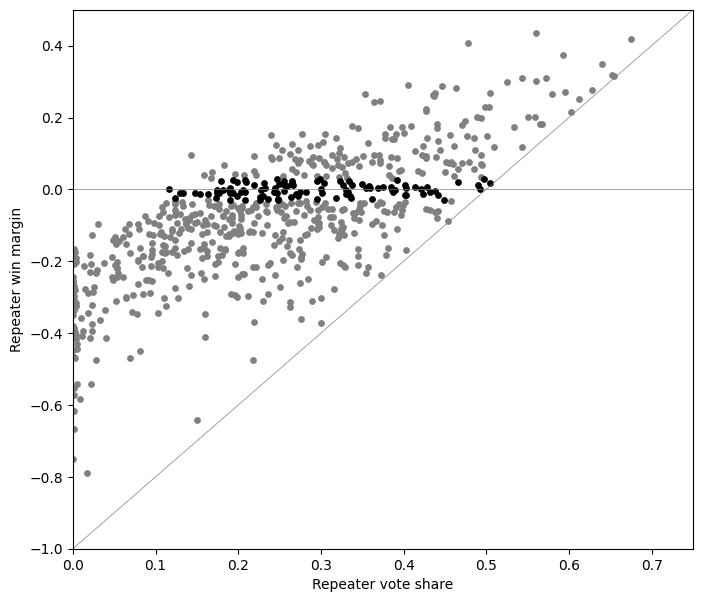

In [195]:
# Dibuja la figura con el tamaño especificado
plt.figure(figsize=(8, 7))  # Set the figure size

# Separa los puntos que están en el rango de -0.1 a 0.1 en y
mask = (dffg[f"diferencia_{año_t1}"] >= -0.03) & (dffg[f"diferencia_{año_t1}"] <= 0.03)
outside_range = dffg[~mask]
inside_range = dffg[mask]

# Puntos fuera del rango en gris
plt.scatter(outside_range[f"votos_porcentaje_{año_t1}"], outside_range[f"diferencia_{año_t1}"], alpha=1, color='grey', s = 15)
plt.scatter(inside_range[f"votos_porcentaje_{año_t1}"], inside_range[f"diferencia_{año_t1}"], alpha=1, color='black',  s = 15)

# Valores para la línea de y = -1 + 2x
x_vals = np.array([0, 1])
y_vals = -1 + 2 * x_vals
plt.plot(x_vals, y_vals, color='gray', linestyle='-', linewidth=0.5)
plt.xlabel("Repeater vote share")
plt.ylabel("Repeater win margin")

# Establece los límites de los ejes como se ha solicitado
plt.xlim(0, 0.75)
plt.ylim(-1, 0.5)
plt.axhline(0, color='gray', linewidth=0.5)

plt.savefig(f"{carpeta1}/vote_share_win_margin.png", dpi = 300)

## Base de dependientes y controles

In [196]:
variables = "INPUT_2_DATAMUNICIPAL"
dependientes = pd.read_csv(f"{variables}//dependientes.csv")
dependientes = dependientes[["codmpio", "date", "deuda_pc"]]

In [197]:
controles = pd.read_csv(f"{variables}//controles.csv")
controles = controles.rename(columns={"ano":"date"})

ids = ["codmpio", "date"]
inst_hist = ['ao_crea', 'dist_creal']
inst_cont = ['indrural', 'discapital', 's11_total']
fiscal    = ['DF_ahorro', 'DF_desemp_fisc', 'DI_eficacia', 'DI_eficiencia', 'DI_capadmin', 'DI_desemp_int']
geo       = ['areaoficialkm2', 'pobl_tot', 'altura', 'lat', 'long', 'dmagdalena', 'dcauca', 'dcosta']
fex       = ['gandina', 'gcaribe', 'gpacifica','gorinoquia', 'gamazonia', 'coddepto']

lista_controles = inst_hist + inst_cont + fiscal + geo + fex 

controles = controles[ids + lista_controles]

In [198]:
df = pd.merge(dependientes, dff, "inner", ["codmpio"])
df = pd.merge(df, controles, "inner", ["codmpio", "date"])

## Test de balanceo

In [199]:
año_control  = 2015

# List to hold results
results = []
# print(año_control-4, año_control)

for Y in df:
    
    # dfmedias = df[(df.date>=año_control-4) & (df.date<año_control)]
    dfmedias = df[(df.date>=año_control)]
    # dfmedias

    try:
        XT = dfmedias[dfmedias[f"diferencia_{año_t1}"] >= 0][Y].dropna()
        XN = dfmedias[dfmedias[f"diferencia_{año_t1}"] < 0][Y].dropna()

        mean_XT = XT.mean()
        mean_XN = XN.mean()
        diff_means = mean_XT - mean_XN

        t_stat, p_value = ttest_ind(XT, XN)

        results.append([Y, mean_XT, mean_XN, diff_means, p_value])

    except:
        None

# Convert results into a DataFrame
results_df = pd.DataFrame(results, columns=['Variable', 'Mean_XT', 'Mean_XN', 'Difference', 'P-value'])
results_df.to_excel(f"{carpeta1}/balanceo.xlsx")


## Prueba de densidad (McCrary)

In [201]:
from scipy.stats import norm

### Margin

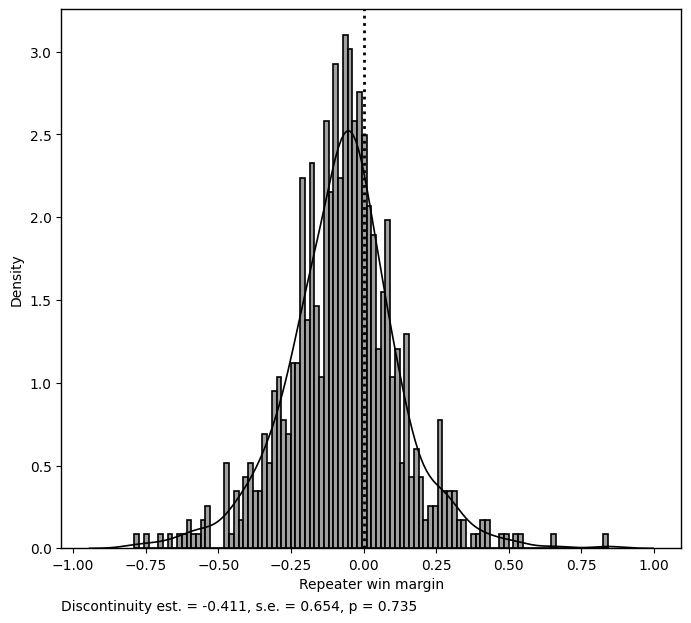

In [202]:
dfm = df[df.date == año_t1]
dfm = dfm[np.abs(dfm[f"diferencia_{año_t1}"])<abs(1)]
RV = dfm[f"diferencia_{año_t1}"].dropna()

rdd = rddensity.rddensity(X=RV)
DIF = round(rdd.hat["diff"],3)
EE = round(rdd.sd_jk["diff"],3)
Z = DIF/EE
PMCRARY = round(1 - norm.cdf(Z),3)

texto = f"Discontinuity est. = {DIF}, s.e. = {EE}, p = {PMCRARY}"

plt.figure(figsize=(8, 7))  # Set the figure size
plt.axvline(0, color='black', linestyle='dotted', linewidth=2)
sns.histplot(RV, bins=100, stat="density", color="gray", kde=False, edgecolor="black", linewidth = 1.2)
sns.kdeplot(RV, color="black", linewidth = 1.2)
plt.xlabel('Repeater win margin')
plt.ylabel('Density')
plt.grid(False)
spines_to_set = ['top', 'right', 'bottom', 'left']
for spine in spines_to_set:
    plt.gca().spines[spine].set_visible(True)
    plt.gca().spines[spine].set_linewidth(1)  # Establece el grosor de la línea
    plt.gca().spines[spine].set_edgecolor('black')  # Establece el color de la línea

plt.text(0, -0.12, texto, transform=plt.gca().transAxes, ha='left', va='bottom')

# plt.to_excel(f"{carpeta}/histogram")
plt.savefig(f"{carpeta1}/Mcrary_Margin.png", dpi = 300)

plt.show()




### Council

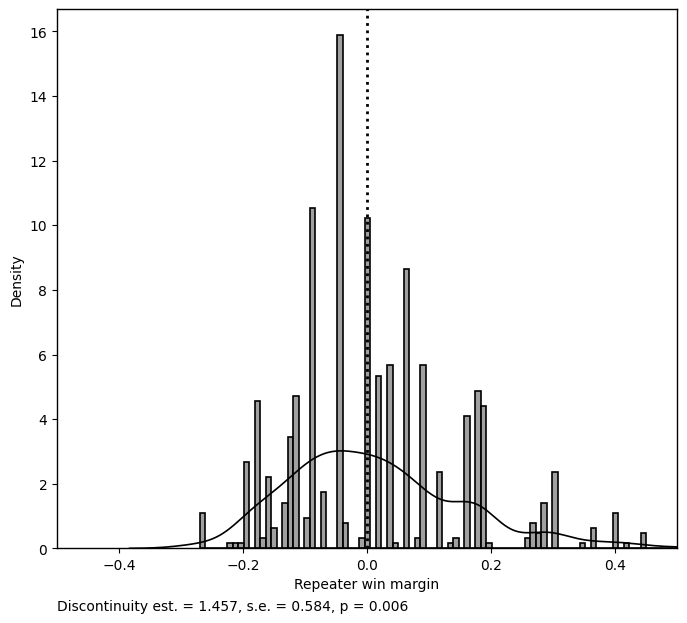

In [203]:
dfm = df[df.date == año_t1]
dfm = dfm[np.abs(dfm[f"curules_share_{año_t1}"])<abs(1)]
RV = dfm[f"curules_share_{año_t1}"].dropna() - 0.27

rdd = rddensity.rddensity(X=RV)
DIF = round(rdd.hat["diff"],3)
EE = round(rdd.sd_jk["diff"],3)
Z = DIF/EE
PMCRARY = round(1 - norm.cdf(Z),3)

texto = f"Discontinuity est. = {DIF}, s.e. = {EE}, p = {PMCRARY}"

plt.figure(figsize=(8, 7))  # Set the figure size
plt.rcdefaults()
plt.axvline(0, color='black', linestyle='dotted', linewidth=2)
sns.histplot(RV, bins=100, stat="density", color="gray", kde=False, edgecolor="black", linewidth = 1.2)
sns.kdeplot(RV, color="black", linewidth = 1.2)
plt.xlabel('Repeater win margin')
plt.ylabel('Density')
plt.grid(False)
spines_to_set = ['top', 'right', 'bottom', 'left']
for spine in spines_to_set:
    plt.gca().spines[spine].set_visible(True)
    plt.gca().spines[spine].set_linewidth(1)  # Establece el grosor de la línea
    plt.gca().spines[spine].set_edgecolor('black')  # Establece el color de la línea

plt.text(0, -0.12, texto, transform=plt.gca().transAxes, ha='left', va='bottom')

# plt.to_excel(f"{carpeta}/histogram")
plt.savefig(f"{carpeta1}/Mcrary_Council.png", dpi = 300)

plt.xlim(-0.5,0.5)

plt.show()


# Regresiones

In [208]:
df["deuda_pc"] = np.log(1+df["deuda_pc"])

## Regresion principal: margen ganador

### Organización base + parametros

In [210]:
def imputar_percentil(geohistf):
    for column in geohistf.columns:
        if geohistf[column].isna().any():
            # Calcular el percentil 76 para la columna actual
            percentile_76 = np.percentile(geohistf[column].dropna(), 50)
            # Imputar este percentil donde haya NaNs
            geohistf[column].fillna(percentile_76, inplace=True)
    return geohistf

In [211]:
#PARAMETROS
limite = 1
threshold = 0
año = año_t1+1
Y = "deuda_pc"

#FIX BASELINE BASE
d = df[(df.date==año)]
d["X"] = d[f"diferencia_{año_t1}"].copy()
d["Y"] = d[Y]
d = d[np.abs(d["X"])<=limite]
d['const'] = 1
d["T"] = d["X"].apply(lambda x: 1 if x>=threshold else 0)
d['XT'] = d['X'] * d['T']

dptos = pd.get_dummies(d.coddepto, prefix="dpto", drop_first="True")
d = d.drop(columns = "coddepto"); d = pd.concat([d,dptos],axis = 1)
departamentos = list(dptos.columns)
d = imputar_percentil(d)


dd = d[["Y", "X", "T", "XT"]].dropna()
est1 = rdrobust(y=dd["Y"], x=dd["X"], p=1, deriv=1, kernel = "uniform", all = True, vce='hc0',  c=threshold)
b_optimo = est1.bws.loc["b"][0]


### Funciones claves

In [212]:
#FUNCIÓN PARA LA SIGNIFICANCIA

def significance(p_value):
    if p_value < 0.01:
        return '***'
    elif p_value < 0.05:
        return '**'
    elif p_value < 0.1:
        return '*'
    else:
        return ''

#FUNCIÓN PARA LA REGRESION y ORGANIZARLA EN LAS TABLAS QUE NECESITAMOS
def regresion_tablav2(sumario, results, variables, bandwidth, media_dependiente):
    # Suponiendo que 'sumario' y 'results' son objetos ya definidos y accesibles

    # Extracción de datos
    N = sumario.tables[0].iloc[3,1]
    R = sumario.tables[0].iloc[6,1]

    # Creación y modificación de coef_df
    coef_df = sumario.tables[1][["Coef.", "Std.Err.","P>|t|"]]
    coef_df = coef_df.T[["const", "X", "T", "XT"]].T

    # Aplicar formato y agregar nuevas columnas
    coef_df['p'] = coef_df['P>|t|'].apply(significance)
    coef_df["coef"] = coef_df.apply(lambda row: f"{round(row['Coef.'], 3)}{row['p']}", axis=1)
    coef_df["std"] = coef_df["Std.Err."].round(3).apply(lambda x: f"({x})")

    # # Seleccionar y reordenar columnas
    coef_df = coef_df[["coef", "std"]].loc[["X", "T", "XT"]]

    # Reestructuración final del DataFrame
    coef_df = pd.DataFrame({"coef/std": coef_df.stack()}).reset_index(level=1, drop=True)

    coef_df.loc["e1"] = [""]
    coef_df.loc["e2"] = [""]
    coef_df.loc["Outcome mean"] = media_dependiente
    coef_df.loc["Bandwith"] = bandwidth
    coef_df.loc["R2"] = R
    coef_df.loc["Observations"] = N

    return coef_df

## Regresión variando controles

In [213]:
fex  = ['gandina', 'gcaribe', 'gpacifica','gorinoquia', 'gamazonia'] + departamentos
lista_controles2 = [[], inst_hist , inst_hist + inst_cont , inst_hist + inst_cont + fiscal,  inst_hist + inst_cont + fiscal + geo, inst_hist + inst_cont + fiscal + geo + fex]
lista_controles_completa = inst_hist + inst_cont + fiscal + geo + fex

In [214]:
tabla_regresion = pd.DataFrame()
for lista in lista_controles2:
    # print(lista)
    dd = d[["Y", "const", "X", "T", "XT"]+lista].dropna()
    media = round(dd["Y"].mean(),3)
    # dd["Y"] = np.log(1+dd["Y"])
    model = sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']+lista]).fit()
    sumario = model.summary2()
    variables = list(sumario.tables[1].index)
    tabla = regresion_tablav2(sumario, results, variables, "1", media)
    tabla_regresion = pd.concat([tabla_regresion, tabla], axis = 1)

In [215]:
tabla_regresion.to_excel(f"{carpeta2}/0REGCONTROL.xlsx")
tabla_regresion

,coef/std,coef/std,coef/std,coef/std,coef/std,coef/std
X,0.012,0.013,-0.001,0.0,0.007,-0.007
X,(0.035),(0.035),(0.035),(0.034),(0.034),(0.034)
T,-0.01,-0.011,-0.006,-0.006,-0.007,-0.005
T,(0.012),(0.012),(0.012),(0.012),(0.012),(0.012)
XT,0.211***,0.208***,0.229***,0.226***,0.213***,0.245***
XT,(0.065),(0.066),(0.065),(0.065),(0.064),(0.065)
e1,,,,,,
e2,,,,,,
Outcome mean,0.068,0.068,0.068,0.068,0.068,0.068
Bandwith,1,1,1,1,1,1


#### Gráfica

In [216]:
dk = dd.copy()
model = sm.OLS(dk['Y'], dk[['const', 'X', 'T', 'XT']]).fit()
model2 = sm.OLS(dk['Y'], dk[['const', 'X', 'T', 'XT']+lista_controles_completa]).fit()
K = pd.DataFrame()
# K["Y"] = dk["Y"].values
K["Y"] = model2.predict()
K["X"] = dk["X"].values
K["y_pred"] = model.predict()
params = model.params

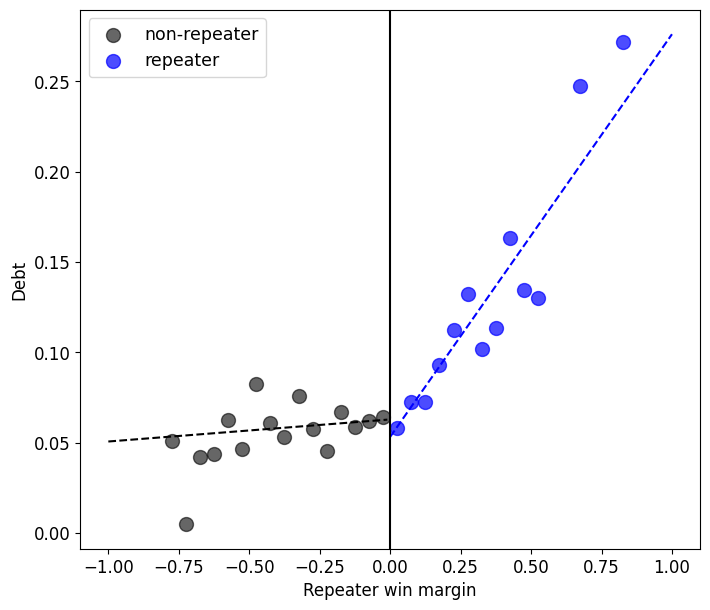

In [217]:
# Crear bines para X
plt.figure(figsize=(8, 7)) 

plt.rcParams.update({'font.size': 12})  

bin_size = 0.05
bins = np.arange(-1, 1 + bin_size, bin_size)
K['bin'] = pd.cut(K['X'], bins, labels=(bins[:-1] + bin_size / 2), right=False)

grouped = K.groupby('bin')[["Y", "y_pred"]].mean().reset_index()
grouped['bin'] = grouped['bin'].astype(float)

before_threshold = grouped[grouped['bin'] < threshold]
after_threshold = grouped[grouped['bin'] >= threshold]

plt.scatter(before_threshold['bin'], before_threshold['Y'], color='black', alpha=0.6, s = 100, label = "non-repeater")
plt.scatter(after_threshold['bin'], after_threshold['Y'], color='blue', alpha=0.7, s = 100, label = "repeater")

X_before = np.linspace(-1, 0, 100, endpoint=False)
X_after = np.linspace(0, 1, 100)
Y_before = params['const'] + params['X'] * X_before  # Para X < 0
Y_after = (params['const'] + params['T']) + (params['X'] + params['XT']) * X_after  # Para X >= 0

plt.plot(X_before, Y_before, color='black', linestyle='--')
plt.plot(X_after, Y_after, color='blue', linestyle='--')

plt.axvline(x=threshold, color='black', linestyle='-')

plt.xlabel('Repeater win margin')
plt.ylabel('Debt')

plt.legend(fontsize=12.5)

## Regresión variando bandwidths

In [220]:
bandas = [1,1,b_optimo, b_optimo, b_optimo/2, b_optimo*2]
bandas = [1,1,b_optimo, b_optimo,  b_optimo,  b_optimo]
controles = [0,1,0,1,0,1]
dh = [0,0,0,0,1,1]

tabla_regresion = pd.DataFrame()

for b,c,dk in zip(bandas, controles, dh):
    dr = d.copy()

    if b<1:
        if dk==1:
            dr = dr[np.abs(dr["X"])>=b]
        else:
             dr = dr[np.abs(dr["X"])<=b]

    cont = []
    if c == 0:
        cont = []
    else:
        cont = lista_controles_completa.copy()

    media = round(dr["Y"].mean(),3)

    model = sm.OLS(dr['Y'], dr[['const', 'X', 'T', 'XT']+cont])
    results = model.fit()
    sumario = results.summary2()

    variables = list(sumario.tables[1].index)
    tabla = regresion_tablav2(sumario, results, variables, round(b,3), media)
    tabla_regresion = pd.concat([tabla_regresion, tabla], axis = 1)

In [221]:
tabla_regresion.to_excel(f"{carpeta2}/1REGBAND.xlsx")
tabla_regresion

,coef/std,coef/std,coef/std,coef/std,coef/std,coef/std
X,0.012,-0.007,0.047,0.047,-0.009,-0.004
X,(0.035),(0.034),(0.109),(0.107),(0.078),(0.081)
T,-0.01,-0.005,0.008,0.012,-0.062,-0.075
T,(0.012),(0.012),(0.015),(0.015),(0.051),(0.052)
XT,0.211***,0.245***,-0.104,-0.095,0.415***,0.442***
XT,(0.065),(0.065),(0.18),(0.175),(0.16),(0.164)
e1,,,,,,
e2,,,,,,
Outcome mean,0.068,0.068,0.065,0.065,0.071,0.071
Bandwith,1,1,0.166,0.166,0.166,0.166


## Regresión año a año

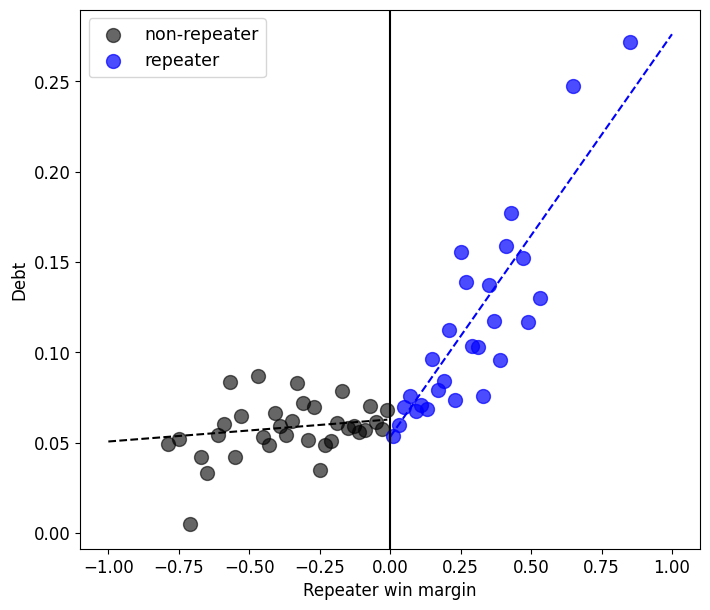

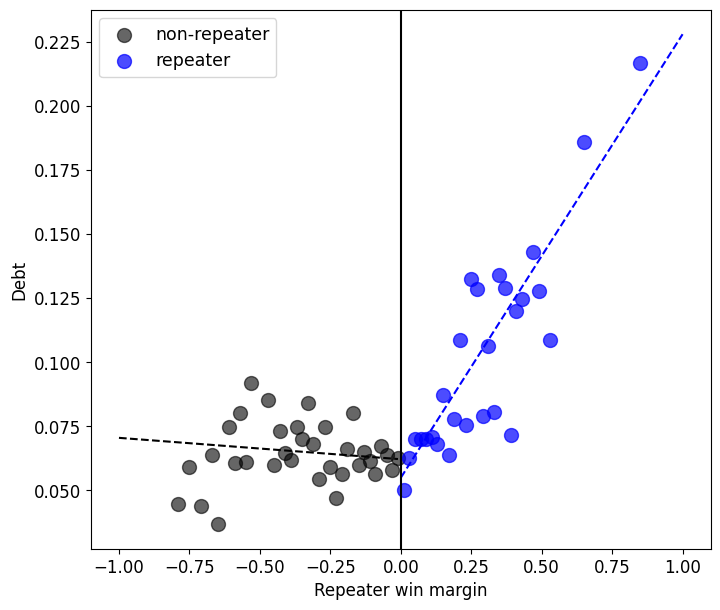

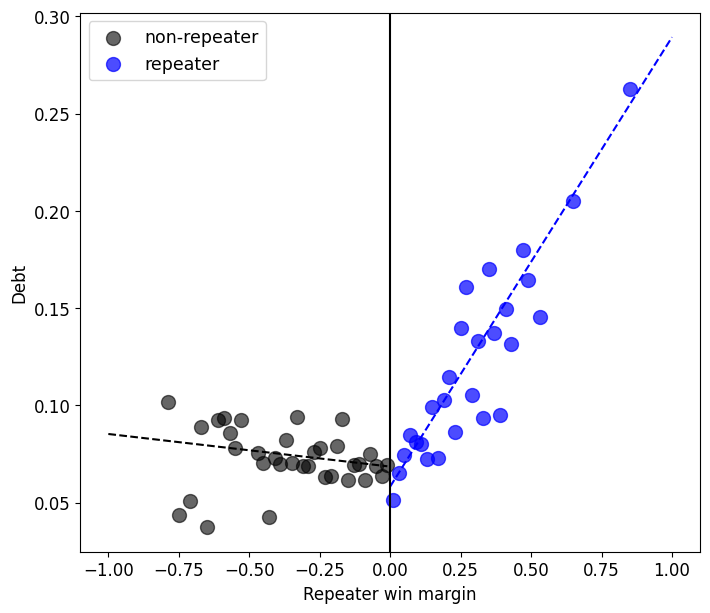

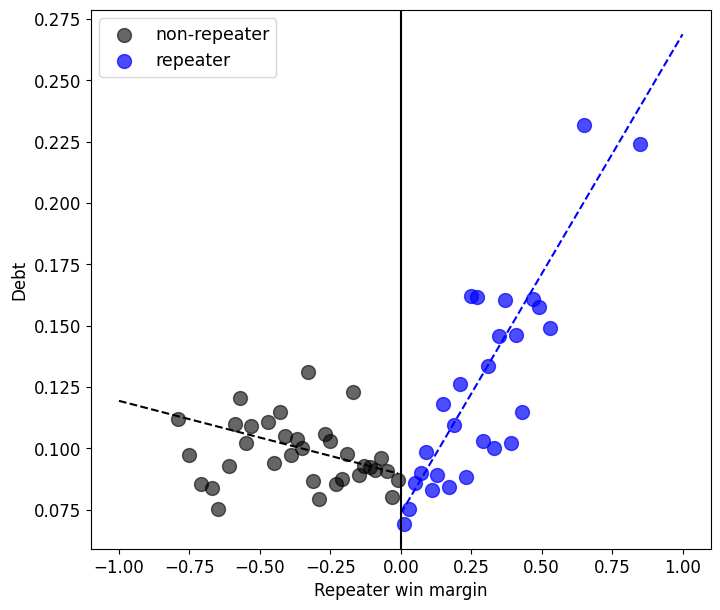

In [222]:
tabla_regresion = pd.DataFrame()

for year in range(año_t1+1,año_t1+5):

    lc = lista_controles_completa.copy()

    # print(year)

    limite = 1
    threshold = 0
    Y = "deuda_pc"

    #FIX BASELINE BASE
    dkk = df[(df.date==year)]


    columns_to_drop = [col for col in dkk.columns if dkk[col].isnull().sum() > 100]
    dkk = dkk.drop(columns=columns_to_drop)
    lc = [col for col in lc if col not in columns_to_drop]


    dkk["X"] = dkk[f"diferencia_{año_t1}"].copy()
    dkk["Y"] = dkk[Y]
    dkk = dkk[np.abs(dkk["X"])<=limite]
    dkk['const'] = 1
    dkk["T"] = dkk["X"].apply(lambda x: 1 if x>=threshold else 0)
    dkk['XT'] = dkk['X'] * dkk['T']

    dptos = pd.get_dummies(dkk.coddepto, prefix="dpto", drop_first="True")
    dkk = dkk.drop(columns = "coddepto"); dkk = pd.concat([dkk,dptos],axis = 1)
    departamentos = list(dptos.columns)
    dkk = imputar_percentil(dkk)

    ddk = dkk[["Y", "const", "X", "T", "XT"]+lc].dropna()
    media = round(ddk["Y"].mean(),3)
    model = sm.OLS(ddk['Y'], ddk[['const', 'X', 'T', 'XT']+lc]).fit()
    sumario = model.summary2()
    variables = list(sumario.tables[1].index)
    tabla = regresion_tablav2(sumario, results, variables, "1", media)
    tabla_regresion = pd.concat([tabla_regresion, tabla], axis = 1)



####################################################################################################
    dk = ddk.copy()
    # dk["Y"] = np.log(1+dk["Y"])
    model = sm.OLS(dk['Y'], dk[['const', 'X', 'T', 'XT']]).fit()
    model2 = sm.OLS(dk['Y'], dk[['const', 'X', 'T', 'XT']+lc]).fit()
    K = pd.DataFrame()
    # K["Y"] = dk["Y"].values
    K["Y"] = model2.predict()
    K["X"] = dk["X"].values
    K["y_pred"] = model.predict()
    params = model.params


    plt.figure(figsize=(8, 7)) 

    plt.rcParams.update({'font.size': 12})  

    bin_size = 0.02
    bins = np.arange(-1, 1 + bin_size, bin_size)
    K['bin'] = pd.cut(K['X'], bins, labels=(bins[:-1] + bin_size / 2), right=False)

    grouped = K.groupby('bin')[["Y", "y_pred"]].mean().reset_index()
    grouped['bin'] = grouped['bin'].astype(float)

    before_threshold = grouped[grouped['bin'] < threshold]
    after_threshold = grouped[grouped['bin'] >= threshold]

    plt.scatter(before_threshold['bin'], before_threshold['Y'], color='black', alpha=0.6, s = 100, label = "non-repeater")
    plt.scatter(after_threshold['bin'], after_threshold['Y'], color='blue', alpha=0.7, s = 100, label = "repeater")

    X_before = np.linspace(-1, 0, 100, endpoint=False)
    X_after = np.linspace(0, 1, 100)
    Y_before = params['const'] + params['X'] * X_before  # Para X < 0
    Y_after = (params['const'] + params['T']) + (params['X'] + params['XT']) * X_after  # Para X >= 0

    # plt.plot(X_before, Y_before, color='black', linestyle='--', label=r'$\haty_i=\alpha+\beta x_i+\epsilon_{i\ }$')
    # plt.plot(X_after, Y_after, color='blue', linestyle='--', label=r'$\haty_i=\alpha+\beta x_i+\tau t_i+\phi t_ix_i+\epsilon_{i\ }$')

    plt.plot(X_before, Y_before, color='black', linestyle='--')
    plt.plot(X_after, Y_after, color='blue', linestyle='--')

    plt.axvline(x=threshold, color='black', linestyle='-')

    plt.xlabel('Repeater win margin')
    plt.ylabel('Debt')

    plt.legend(fontsize=12.5)

    plt.savefig(f"{carpeta3}/0SCATTER_BASELINE_{year}.png", dpi = 300)


In [223]:
tabla_regresion.to_excel(f"{carpeta2}/2REGYEARS.xlsx")
tabla_regresion

,coef/std,coef/std,coef/std,coef/std
X,-0.007,-0.016,-0.025,-0.063*
X,(0.034),(0.03),(0.032),(0.036)
T,-0.005,-0.006,-0.009,-0.009
T,(0.012),(0.011),(0.011),(0.013)
XT,0.245***,0.197***,0.258***,0.27***
XT,(0.065),(0.058),(0.061),(0.068)
e1,,,,
e2,,,,
Outcome mean,0.068,0.068,0.077,0.096
Bandwith,1,1,1,1


## Robustez

### Placebo (variando tratamiento)

https://docs.iza.org/dp8282.pdf

https://github.com/ganong-noel/rdpermute/tree/master

In [224]:
limite = 1
threshold = 0
año = año_t1+1
Y = "deuda_pc"

d = df[(df.date==año)]
d["X"] = d[f"diferencia_2015"].copy()
d["Y"] = d[Y]
d = d[np.abs(d["X"])<=limite]
d['const'] = 1
d["T"] = d["X"].apply(lambda x: 1 if x>=threshold else 0)
d['XT'] = d['X'] * d['T']

dptos = pd.get_dummies(d.coddepto, prefix="dpto", drop_first="True")
d = d.drop(columns = "coddepto"); d = pd.concat([d,dptos],axis = 1)
departamentos = list(dptos.columns)

d = imputar_percentil(d)

In [225]:
fex  = ['gandina', 'gcaribe', 'gpacifica','gorinoquia', 'gamazonia'] + departamentos
lista_controles2 = [[], inst_hist , inst_hist + inst_cont , inst_hist + inst_cont + fiscal,  inst_hist + inst_cont + fiscal + geo, inst_hist + inst_cont + fiscal + geo + fex]
lista_controles_completa = inst_hist + inst_cont + fiscal + geo + fex

In [228]:
placebos =  []
vplacebos = []


np.random.seed(1820) 

for i in tqdm(range(0,1000)):

    placebos.append(i)
    ddp = d.copy().reset_index(drop = True)
    ddp['Y'] = ddp['Y'].sample(frac=1).reset_index(drop=True)
    model = sm.OLS(ddp['Y'], ddp[['const', 'X', 'T', 'XT']]).fit()
    sumario = model.summary2()
    coef_df = sumario.tables[1][["Coef.", "Std.Err.","P>|t|"]]
    coef_df = coef_df.T[["const", "X", "T", "XT"]]
    xt = coef_df.loc["Coef.", "XT"]
    vplacebos.append(xt)


placebos = pd.DataFrame(zip(placebos, vplacebos), columns = ["treshold", "XT"])    

min_coef = round(placebos.XT.min(),3)
max_coef = round(placebos.XT.max(),3)

results = []
NPLA = placebos.shape[0]
for i in np.arange(min_coef, max_coef, 0.01):
    prob = (placebos["XT"] <= i).sum() / NPLA
    results.append({"coef": i, "P<=coef": prob})
placebos_cdf = pd.DataFrame(results)

max_coef

  1%|          | 9/1000 [00:00<00:29, 33.61it/s]

100%|██████████| 1000/1000 [00:20<00:00, 47.71it/s]


0.353

#### CDF

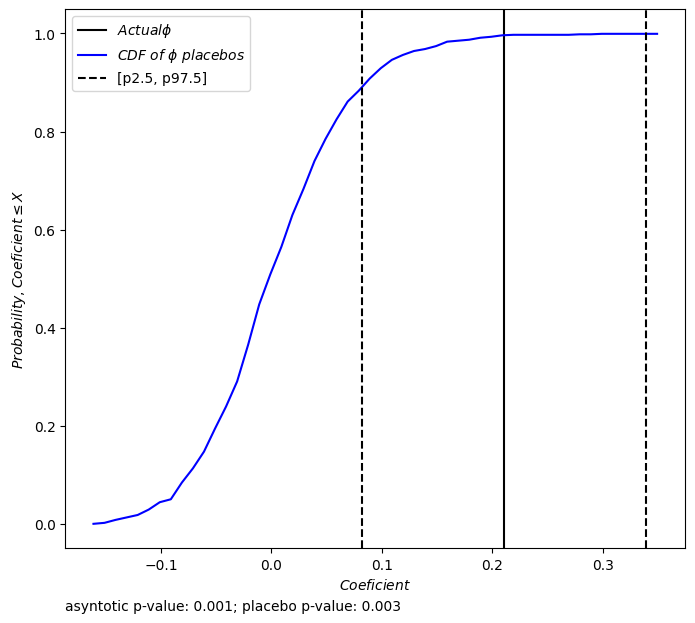

In [239]:
# Crear el line plot
plt.figure(figsize=(8, 7))  # Cambia el tamaño según necesites
plt.rcdefaults()

modelp = sm.OLS(d['Y'], d[['const', 'X', 'T', 'XT']]).fit().summary2()

truec = modelp.tables[1][["Coef.", "[0.025", "0.975]"]].loc["XT"]["Coef."]
true_is = modelp.tables[1][["Coef.", "[0.025", "0.975]"]].loc["XT"]["0.975]"]
true_ii = modelp.tables[1][["Coef.", "[0.025", "0.975]"]].loc["XT"]["[0.025"]

pvalue_ols = round(modelp.tables[1][["Coef.", "[0.025", "0.975]", "P>|t|"]].loc["XT"]["P>|t|"],3)
pvalue_placebo = round(1 - ((placebos["XT"] <= truec).sum() / NPLA),3)

plt.axvline(x=truec, color='black', linestyle='-', label = r"$Actual \phi$")

plt.plot(placebos_cdf['coef'], placebos_cdf['P<=coef'], label=r"$CDF \ of \ \phi  \ placebos$", color ="blue")

plt.axvline(x=true_ii, color='black', linestyle='--', label = "[p2.5, p97.5]")
plt.axvline(x=true_is, color='black', linestyle='--')

plt.xlabel(r'$Coeficient$')  # Etiqueta del eje X
plt.ylabel(r'$Probability,Coeficient \leq X$')  # Etiqueta del eje Y
# plt.title('Line Plot de placebos_cdf con Líneas Verticales')  # Título del gráfico
plt.legend()  # Muestra la leyenda

plt.text(0, -0.12, f'asyntotic p-value: {pvalue_ols}; placebo p-value: {pvalue_placebo}', transform=plt.gca().transAxes, ha='left', va='bottom')


plt.savefig(f"{carpeta4}/0PLACEBO_RD_CDF.png", dpi = 300)
plt.show()

#### PDF

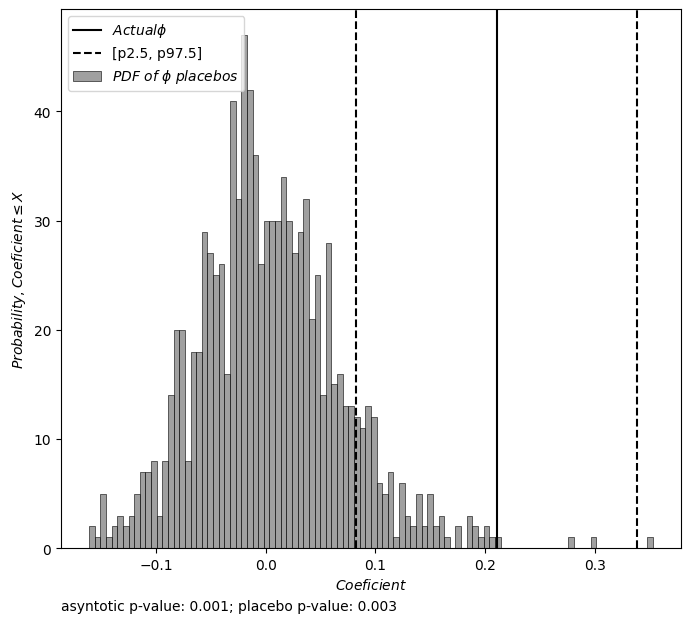

In [241]:
# Crear el line plot
plt.figure(figsize=(8, 7))  # Cambia el tamaño según necesites
plt.rcdefaults()

plt.axvline(x=truec, color='black', linestyle='-', label = r"$Actual \phi$")

sns.histplot(placebos['XT'], label=r"$PDF \ of \ \phi  \ placebos$", color ="gray", bins = 100)

plt.axvline(x=true_ii, color='black', linestyle='--', label = "[p2.5, p97.5]")
plt.axvline(x=true_is, color='black', linestyle='--')

plt.xlabel(r'$Coeficient$')  # Etiqueta del eje X
plt.ylabel(r'$Probability,Coeficient \leq X$')  # Etiqueta del eje Y
# plt.title('Line Plot de placebos_cdf con Líneas Verticales')  # Título del gráfico
plt.legend(loc='upper left')

plt.text(0, -0.12, f'asyntotic p-value: {pvalue_ols}; placebo p-value: {pvalue_placebo}', transform=plt.gca().transAxes, ha='left', va='bottom')


plt.savefig(f"{carpeta4}/1PLACEBO_RD_PDF.png", dpi = 300)
plt.show()

### Placebo: X de 2011 en Y de 2016

In [246]:
limite = 1
threshold = 0
año = año_t1+1
Y = "deuda_pc"

#FIX BASELINE BASE
X11 = pd.read_excel("OUT_2_TESTS/2011_X.xlsx")
d = df[(df.date==año)]
d = d.merge(X11, "left", "codmpio")
d = d[d.diferencia_2011.notna()]
d["X"] = d[f"diferencia_2011"].copy()
d["Y"] = d[Y]
d = d[np.abs(d["X"])<=limite]
d['const'] = 1
d["T"] = d["X"].apply(lambda x: 1 if x>=threshold else 0)
d['XT'] = d['X'] * d['T']

dptos = pd.get_dummies(d.coddepto, prefix="dpto", drop_first="True")
d = d.drop(columns = "coddepto"); d = pd.concat([d,dptos],axis = 1)
departamentos = list(dptos.columns)

d = imputar_percentil(d)


In [247]:
fex  = ['gandina', 'gcaribe', 'gpacifica','gorinoquia', 'gamazonia'] + departamentos
lista_controles2 = [[], inst_hist , inst_hist + inst_cont , inst_hist + inst_cont + fiscal,  inst_hist + inst_cont + fiscal + geo, inst_hist + inst_cont + fiscal + geo + fex]
lista_controles_completa = inst_hist + inst_cont + fiscal + geo + fex

In [248]:
tabla_regresion = pd.DataFrame()
for lista in lista_controles2:
    # print(lista)
    dd = d[["Y", "const", "X", "T", "XT"]+lista].dropna()
    media = round(dd["Y"].mean(),3)
    # dd["Y"] = np.log(1+dd["Y"])
    model = sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']+lista]).fit()
    sumario = model.summary2()
    variables = list(sumario.tables[1].index)
    tabla = regresion_tablav2(sumario, results, variables, "1", media)
    tabla_regresion = pd.concat([tabla_regresion, tabla], axis = 1)

In [249]:
tabla_regresion.to_excel(f"{carpeta4}/0RD_X2011.xlsx")
tabla_regresion

,coef/std,coef/std,coef/std,coef/std,coef/std,coef/std
X,0.021,0.016,0.01,0.006,-0.001,-0.0
X,(0.04),(0.04),(0.039),(0.039),(0.038),(0.04)
T,0.005,0.004,0.009,0.009,0.002,0.004
T,(0.013),(0.012),(0.012),(0.012),(0.012),(0.012)
XT,-0.073,-0.077,-0.053,-0.045,-0.034,-0.072
XT,(0.075),(0.074),(0.074),(0.073),(0.071),(0.072)
e1,,,,,,
e2,,,,,,
Outcome mean,0.063,0.063,0.063,0.063,0.063,0.063
Bandwith,1,1,1,1,1,1


### Placebo: X de 2019 en Y de 2016

In [250]:
limite = 1
threshold = 0
año = año_t1+1
Y = "deuda_pc"

#FIX BASELINE BASE
X11 = pd.read_excel("OUT_2_TESTS/2019_X.xlsx")
d = df[(df.date==año)]
d = d.merge(X11, "left", "codmpio")
d = d[d.diferencia_2019.notna()]
d["X"] = d[f"diferencia_2019"].copy()
d["Y"] = d[Y]
d = d[np.abs(d["X"])<=limite]
d['const'] = 1
d["T"] = d["X"].apply(lambda x: 1 if x>=threshold else 0)
d['XT'] = d['X'] * d['T']

dptos = pd.get_dummies(d.coddepto, prefix="dpto", drop_first="True")
d = d.drop(columns = "coddepto"); d = pd.concat([d,dptos],axis = 1)
departamentos = list(dptos.columns)

d = imputar_percentil(d)


In [251]:
fex  = ['gandina', 'gcaribe', 'gpacifica','gorinoquia', 'gamazonia'] + departamentos
lista_controles2 = [[], inst_hist , inst_hist + inst_cont , inst_hist + inst_cont + fiscal,  inst_hist + inst_cont + fiscal + geo, inst_hist + inst_cont + fiscal + geo + fex]
lista_controles_completa = inst_hist + inst_cont + fiscal + geo + fex

In [252]:
tabla_regresion = pd.DataFrame()
for lista in lista_controles2:
    # print(lista)
    dd = d[["Y", "const", "X", "T", "XT"]+lista].dropna()
    media = round(dd["Y"].mean(),3)
    # dd["Y"] = np.log(1+dd["Y"])
    model = sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']+lista]).fit()
    sumario = model.summary2()
    variables = list(sumario.tables[1].index)
    tabla = regresion_tablav2(sumario, results, variables, "1", media)
    tabla_regresion = pd.concat([tabla_regresion, tabla], axis = 1)

In [253]:
tabla_regresion.to_excel(f"{carpeta4}/1RD_X2019.xlsx")
tabla_regresion

,coef/std,coef/std,coef/std,coef/std,coef/std,coef/std
X,0.071*,0.072*,0.05,0.047,0.032,0.031
X,(0.037),(0.037),(0.038),(0.037),(0.036),(0.035)
T,-0.022*,-0.022*,-0.016,-0.016,-0.014,-0.018
T,(0.012),(0.012),(0.012),(0.012),(0.012),(0.011)
XT,-0.057,-0.059,-0.045,-0.07,-0.069,-0.023
XT,(0.078),(0.078),(0.077),(0.077),(0.074),(0.073)
e1,,,,,,
e2,,,,,,
Outcome mean,0.066,0.066,0.066,0.066,0.066,0.066
Bandwith,1,1,1,1,1,1


### NO Placebo: X de 2016 en Y de 2011

In [92]:
# dependientes11 = pd.read_csv(f"INPUT_2_DATAMUNICIPAL/dependientes.csv")
# dependientes11 = dependientes11[dependientes11.date==2012][["codmpio", "deuda_pc"]]

# limite = 1
# threshold = 0
# año = año_t1+1

# #FIX BASELINE BASE
# d = df[(df.date==año)]
# d = d.drop(columns = ["deuda_pc"])
# d = d.merge(dependientes11, "left", "codmpio")
# d["X"] = d[f"diferencia_2015"].copy()
# d["Y"] = d["deuda_pc"]
# d = d[np.abs(d["X"])<=limite]
# d['const'] = 1
# d["T"] = d["X"].apply(lambda x: 1 if x>=threshold else 0)
# d['XT'] = d['X'] * d['T']

# dptos = pd.get_dummies(d.coddepto, prefix="dpto", drop_first="True")
# d = d.drop(columns = "coddepto"); d = pd.concat([d,dptos],axis = 1)
# departamentos = list(dptos.columns)

# d = imputar_percentil(d)

# fex  = ['gandina', 'gcaribe', 'gpacifica','gorinoquia', 'gamazonia'] + departamentos
# lista_controles2 = [[], inst_hist , inst_hist + inst_cont , inst_hist + inst_cont + fiscal,  inst_hist + inst_cont + fiscal + geo, inst_hist + inst_cont + fiscal + geo + fex]
# lista_controles_completa = inst_hist + inst_cont + fiscal + geo + fex


# tabla_regresion = pd.DataFrame()
# for lista in lista_controles2:
#     # print(lista)
#     dd = d[["Y", "const", "X", "T", "XT"]+lista].dropna()
#     media = round(dd["Y"].mean(),3)
#     # dd["Y"] = np.log(1+dd["Y"])
#     model = sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']+lista]).fit()
#     sumario = model.summary2()
#     variables = list(sumario.tables[1].index)
#     tabla = regresion_tablav2(sumario, results, variables, "1", media)
#     tabla_regresion = pd.concat([tabla_regresion, tabla], axis = 1)

## Gráficas: consejo + margen

### Organización base

In [255]:
d = df[(df.date==año)]

limite1 = 1
threshold1 = 0

limite2 = 1
# threshold2 = d[f"curules_share_{año_t1}"].median()
threshold2 = 0.5

año = año_t1+1

d["Y"] = d["deuda_pc"]
d["const"] = 1
d["X1"] = d[f"diferencia_{año_t1}"].copy()
d["X2"] = d[f"curules_share_{año_t1}"] - threshold2
d["X1X2"] = d["X1"]*d["X2"]
d["T1"] = np.where(d["X1"] >= 0, 1, 0)
d["T2"] = np.where(d["X2"] >= 0, 1, 0)
d["T1T2"] = d["T1"]*d["T2"]
d["X1T1"] = d["X1"] * d["T1"]
d["X2T2"] = d["X2"] * d["T2"]
d["X1X2T1"] = d["X1"] * d["X2"] * d["T1"]
d["X1X2T2"] = d["X1"] * d["X2"] * d["T2"]
d["X1X2T1T2"] = d["X1"] * d["X2"] * d["T1"] * d["T2"]

d = d[np.abs(d.X1)<1]
d = d[np.abs(d.X1)<1]
d = d.dropna()

### Plot margin vs council

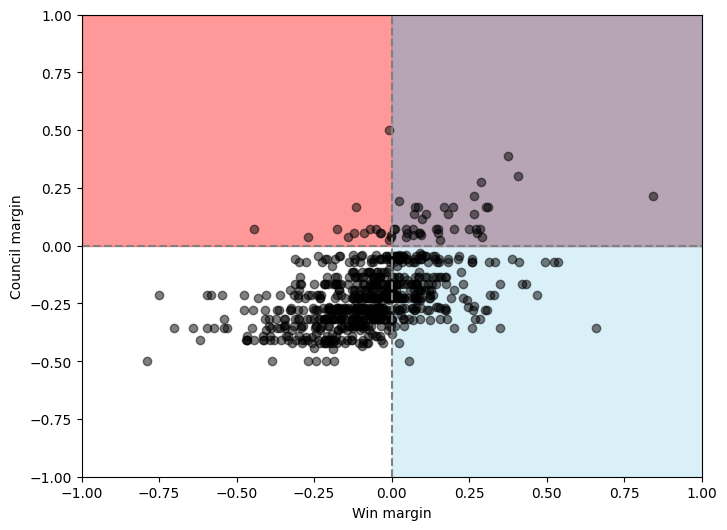

In [256]:
import matplotlib.pyplot as plt

# Supongamos que 'd' es tu DataFrame o diccionario con los datos de las coordenadas X1 y X2
# Por ejemplo:
# d = {'X1': np.random.randn(100), 'X2': np.random.randn(100)}

plt.figure(figsize=(8, 6))

# Sombrear el cuarto cuadrante (X1 >= 0, X2 <= 0)
plt.fill_betweenx(y=[0, 1], x1=-1, x2=0, color='red', alpha=0.4)
plt.fill_betweenx(y=[-1, 0], x1=0, x2=1, color='skyblue', alpha=0.3)

# Sombrear el primer cuadrante (X1 >= 0, X2 >= 0)
# plt.fill_betweenx(y=[0, 1], x1=0, x2=1, color='darkgray', alpha=0.7)

plt.fill_betweenx(y=[0, 1], x1=0, x2=1, color='red', alpha=0.6)
plt.fill_betweenx(y=[0, 1], x1=0, x2=1, color='skyblue', alpha=0.6)


# # Sombrear el cuarto cuadrante (X1 >= 0, X2 <= 0)
# plt.fill_betweenx(y=[0, 1], x1=-1, x2=0, color='gray', alpha=0.3)
# plt.fill_betweenx(y=[-1, 0], x1=0, x2=1, color='blue', alpha=0.5)

# # Sombrear el primer cuadrante (X1 >= 0, X2 >= 0)
# # plt.fill_betweenx(y=[0, 1], x1=0, x2=1, color='darkgray', alpha=0.7)

# plt.fill_betweenx(y=[0, 1], x1=0, x2=1, color='gray', alpha=0.3)
# plt.fill_betweenx(y=[0, 1], x1=0, x2=1, color='blue', alpha=0.2)

plt.scatter(d["X1"], d["X2"], color='black', alpha=0.5)  # Scatterplot de X1 vs X2

# Dibujar una línea vertical y una horizontal en escala de grises
plt.axvline(x=0, color='gray', linestyle='--')
plt.axhline(y=0, color='gray', linestyle='--')



# Establecer los límites para los ejes
plt.xlim(-1, 1)  # Límites para X1
plt.ylim(-1, 1)  # Límites para X2

# Títulos y etiquetas
plt.xlabel('Win margin')
plt.ylabel('Council margin')

# Mostrar el gráfico

plt.savefig(f"{carpeta5}/0COUNCIL_MARGINVOTE_XY.png", dpi = 300)
plt.show()


In [258]:

# # Variables para el modelo
variables_modelo = ["const", "X1", "X2", "T1", "T2", "X1X2", "X1T1", "X2T2"] 
model = sm.OLS(d["Y"],d[variables_modelo]).fit()
coeficientes = model.params

from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interactive, widgets

x1_valores = np.linspace(-1, 1, 100)
x2_valores = np.linspace(-1, 1, 100)
X1_mesh, X2_mesh = np.meshgrid(x1_valores, x2_valores)

    # Definir T1 y T2 basado en las condiciones
T1_mesh = (X1_mesh >= 0).astype(int)
T2_mesh = (X2_mesh >= 0).astype(int)

    # Calcular Y predicho en la grilla basado en los coeficientes
Y_pred_mesh = (coeficientes['const'] +
                   coeficientes['X1'] * X1_mesh +
                   coeficientes['X2'] * X2_mesh +
                   coeficientes['T1'] * T1_mesh +
                   coeficientes['T2'] * T2_mesh +
                   coeficientes['X1X2'] * X1_mesh * X2_mesh +
                   coeficientes['X1T1'] * X1_mesh * T1_mesh +
                   coeficientes['X2T2'] * X2_mesh * T2_mesh)


import plotly.graph_objects as go

# Definir los datos para el gráfico
fig = go.Figure(data=[go.Surface(x=X1_mesh, y=X2_mesh, z=Y_pred_mesh, colorscale='YlOrRd')])

# Actualizar el diseño del gráfico
fig.update_layout(
    title=None,
    autosize=False,
    width=800,  # Ajustado para hacer el dibujo más grande
    height=600,  # Ajustado para hacer el dibujo más grande
    margin=dict(l=65, r=50, b=65, t=90),
    scene=dict(  # Personalizar los nombres de los ejes
        xaxis_title='Win margin',
        yaxis_title='Council share',
        zaxis_title='Debt')
)

fig.show()

In [259]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     4.065
Date:                Thu, 11 Apr 2024   Prob (F-statistic):           0.000221
Time:                        20:07:38   Log-Likelihood:                 587.63
No. Observations:                 706   AIC:                            -1159.
Df Residuals:                     698   BIC:                            -1123.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0651      0.013      4.995      0.000       0.039       0.091
X1             0.0325      0.065      0.498      0.619      -0.096       0.161
X2             0.0144      0.045      0.320      0.749      -0.074       0.103
T1            -0.0108      0.013     -0.844      0.399      -0.036       0.014
T2             0.0201      0.025      0.798      0.425      -0.029       0.070
X1X2           0.0899      0.170      0.528      0.598      -0.244       0.424
X1T1           0.1665      0.079      2.117      0.035       0.012       0.321
X2T2           0.0966      0.181      0.533      0.594      -0.259       0.453
==============================================================================
Omnibus:                      785.247   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            91186.055
Skew:                           5.065   Prob(JB):                         0.00
Kurtosis:                      57.747   Cond. No.                         58.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regresión Council

In [260]:
#PARAMETROS
limite = 1
threshold = 0
año = año_t1+1
Y = "deuda_pc"

#FIX BASELINE BASE
d = df[(df.date==año)]
d["X"] = d[f"curules_share_{año_t1}"].copy() - 0.5
d["Y"] = d[Y]
d = d[np.abs(d["X"])<=limite]
d['const'] = 1
d["T"] = d["X"].apply(lambda x: 1 if x>=threshold else 0)
d['XT'] = d['X'] * d['T']

dptos = pd.get_dummies(d.coddepto, prefix="dpto", drop_first="True")
d = d.drop(columns = "coddepto"); d = pd.concat([d,dptos],axis = 1)
departamentos = list(dptos.columns)

d = imputar_percentil(d)


dd = d[["Y", "X", "T", "XT"]].dropna()


In [261]:
fex  = ['gandina', 'gcaribe', 'gpacifica','gorinoquia', 'gamazonia'] + departamentos
lista_controles2 = [[], inst_hist , inst_hist + inst_cont , inst_hist + inst_cont + fiscal,  inst_hist + inst_cont + fiscal + geo, inst_hist + inst_cont + fiscal + geo + fex]
lista_controles_completa = inst_hist + inst_cont + fiscal + geo + fex

In [262]:
tabla_regresion = pd.DataFrame()
for lista in lista_controles2:
    # print(lista)
    dd = d[["Y", "const", "X", "T", "XT"]+lista].dropna()
    media = round(dd["Y"].mean(),3)
    # dd["Y"] = np.log(1+dd["Y"])
    model = sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']+lista]).fit()
    sumario = model.summary2()
    variables = list(sumario.tables[1].index)
    tabla = regresion_tablav2(sumario, results, variables, "1", media)
    tabla_regresion = pd.concat([tabla_regresion, tabla], axis = 1)

In [176]:
tabla_regresion

,coef/std,coef/std,coef/std,coef/std,coef/std,coef/std
X,0.036,0.027,0.069,0.06,0.054,0.032
X,(0.065),(0.066),(0.067),(0.066),(0.066),(0.068)
T,0.001,0.004,0.002,-0.003,-0.006,-0.006
T,(0.043),(0.043),(0.042),(0.042),(0.041),(0.042)
XT,0.747***,0.743***,0.717***,0.808***,0.819***,0.923***
XT,(0.275),(0.275),(0.273),(0.271),(0.267),(0.273)
e1,,,,,,
e2,,,,,,
Outcome mean,0.078,0.078,0.078,0.078,0.078,0.078
Bandwith,1,1,1,1,1,1


## Regresión: Consejo + Council

In [263]:
d = df[(df.date==año)]

limite1 = 1
threshold1 = 0

limite2 = 1
# threshold2 = d[f"curules_share_{año_t1}"].median()
threshold2 = 0.5

año = año_t1+1

d["Y"] = d["deuda_pc"]
d["const"] = 1
d["X1"] = d[f"diferencia_{año_t1}"].copy()
d["X2"] = d[f"curules_share_{año_t1}"] - threshold2

dptos = pd.get_dummies(d.coddepto, prefix="dpto", drop_first="True")
d = d.drop(columns = "coddepto"); d = pd.concat([d,dptos],axis = 1)
departamentos = list(dptos.columns)


d = d[np.abs(d.X1)<1]
d = d[np.abs(d.X1)<1]
d = d.dropna()

d = imputar_percentil(d)

In [264]:
fex  = ['gandina', 'gcaribe', 'gpacifica','gorinoquia', 'gamazonia'] + departamentos
lista_controles2 = [[], inst_hist , inst_hist + inst_cont , inst_hist + inst_cont + fiscal,  inst_hist + inst_cont + fiscal + geo, inst_hist + inst_cont + fiscal + geo + fex]
lista_controles_completa = inst_hist + inst_cont + fiscal + geo + fex

In [266]:
# d['Xo1'] = d.apply(lambda fila: fila['X1'] * fila['X2'] if (fila['X1'] >= 0 and fila['X2'] >= 0) else -abs(fila['X1'] * fila['X2']), axis=1)
# d['Xo2'] = d.apply(lambda fila: min(fila['X1'], fila['X2']) if fila['X1'] >= 0 and fila['X2'] >= 0 else -abs(min(fila['X1'], fila['X2'])), axis=1)

# Re-definimos las funciones para calcular la distancia de un punto al origen
def distancia_manhattan_al_origen_con_signo(x1, x2):
    distancia = abs(x1) + abs(x2)
    if x1 < 0 or x2 < 0:
        distancia *= -1
    return distancia

def distancia_euclidiana_al_origen_con_signo(x1, x2):
    distancia = math.sqrt(x1**2 + x2**2)
    if x1 < 0 or x2 < 0:
        distancia *= -1
    return distancia

# Aplicar las funciones a las columnas 'X1' y 'X2' del DataFrame
d['Xo3'] = d.apply(lambda fila: distancia_manhattan_al_origen_con_signo(fila['X1'], fila['X2']), axis=1)
d['Xo4'] = d.apply(lambda fila: distancia_euclidiana_al_origen_con_signo(fila['X1'], fila['X2']), axis=1)


for Xtipo in ["Xo3", "Xo4"]:
    d["X"] = d[Xtipo].copy()
    d["T"] = d["X"].apply(lambda x: 1 if x>=0 else 0)
    d["XT"] = d["X"]*d["T"]
    d["const"] = 1

    tabla_regresion = pd.DataFrame()

    for lista in lista_controles2:

        # print(lista)
        dd = d[["Y", "const", "X", "T", "XT"]+lista].dropna()
        media = round(dd["Y"].mean(),3)
        # dd["Y"] = np.log(1+dd["Y"])
        model = sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']+lista]).fit()
        sumario = model.summary2()
        variables = list(sumario.tables[1].index)
        tabla = regresion_tablav2(sumario, results, variables, "1", media)
        tabla_regresion = pd.concat([tabla_regresion, tabla], axis = 1)

        # print(tabla_regresion)
    
    tabla_regresion.to_excel(f"{carpeta5}/0RD_COUNCIL_{Xtipo}.xlsx")
    print(tabla_regresion)


              coef/std  coef/std  coef/std  coef/std coef/std  coef/std
X                0.012      0.01     0.013     0.012    0.013     0.003
X              (0.021)   (0.021)   (0.021)    (0.02)   (0.02)    (0.02)
T             -0.077**  -0.076**  -0.066**   -0.059*  -0.059*   -0.053*
T              (0.032)   (0.032)   (0.032)   (0.031)  (0.031)   (0.031)
XT             0.41***  0.408***  0.387***  0.375***  0.37***  0.394***
XT             (0.087)   (0.087)   (0.086)   (0.085)  (0.083)   (0.084)
e1                                                                     
e2                                                                     
Outcome mean     0.068     0.068     0.068     0.068    0.068     0.068
Bandwith             1         1         1         1        1         1
R2               0.048     0.050     0.075     0.116    0.169     0.224
Observations       706       706       706       706      706       706
              coef/std  coef/std  coef/std  coef/std  coef/std  

# Codigo últil sobrante

In [ ]:

# est1 = rdrobust(y=dd["Y"], x=dd["X"], p=1, deriv=1, kernel = "uniform", all = True, h = 100, vce='hc0',  c=threshold) #lineal, OLS
# sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']]).fit().summaty()
# sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']]).fit(cov_type="HC3").summary2()
# A = sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']])
# A.fit?
# sm.OLS(np.log(dd['Y']+1), dd[['const', 'X', 'T', 'XT']]).fit().summary2()
# sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT', 'Tcoal', 'Xcoal', 'XTcoal']]).fit().summary2()
# sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT', 'Tcons', 'Xcons', 'XTcons']]).fit().summary2()
# sm.OLS(np.log(dd['Y']), dd[['const', 'cons', 'T', 'Tcons']]).fit().summary2()
# sm.OLS(np.log(dd['Y']+1), dd[['const', 'coal', 'T', 'Tcoal']]).fit().summary2()

# k = dd[dd["T"]==0]
# C = sm.OLS(k['Y'], k[['const', 'X']]).fit()
# C.summary()
# A = sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']]).fit()
# B = sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XA']]).fit()
# A.summary()
# B.summary()
# 0.1829-0.1854
# regresion_tablav2(B.summary2(), results, variables, round(b,3), 0)
# regresion_tablav1(A.summary2(), results, variables, round(b,3), 0)

# mserd, msetwo, msesum, msecomb1, msecomb2, cerrd, certwo, cersum, cercomb1, cercomb2